In [247]:
# Important libreries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from imblearn.over_sampling import SMOTE


In [248]:
# Data load
data = pd.read_csv("Churn_Modelling.csv")
data.head()



,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [249]:
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [250]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [251]:
# deleting irelevent features
data.drop(columns=['CustomerId', 'Surname'], inplace=True)

In [252]:
data.head()

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [253]:
# dividing the data point for the training and the testing purpose
X = data.drop(columns=['Exited'])
y = data['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [254]:
# Encoding and scaling
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_cols = ['Geography', 'Gender']
encoder.fit(X_train[categorical_cols])


OneHotEncoder(drop='first', sparse_output=False)

In [255]:
X_train_encoded = encoder.transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])
df_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))
df_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))
df_train_encoded.head()

,Geography_Germany,Geography_Spain,Gender_Male
0,0.0,0.0,1.0
1,1.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,1.0,0.0,1.0


In [256]:
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
X_train_final = pd.concat([X_train[numerical_cols].reset_index(drop=True), df_train_encoded.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test[numerical_cols].reset_index(drop=True), df_test_encoded.reset_index(drop=True)], axis=1)
X_train_final.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,753,57,7,0.00,1,1,0,159475.08,0.0,0.0,1.0
1,739,32,3,102128.27,1,1,0,63981.37,1.0,0.0,1.0
2,755,37,0,113865.23,2,1,1,117396.25,1.0,0.0,0.0
3,561,37,5,0.00,2,1,0,83093.25,0.0,0.0,1.0
4,692,49,6,110540.43,2,0,1,107472.99,1.0,0.0,1.0


In [257]:
# apply standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)


In [258]:
# model training
model = Sequential()

# Input layer
model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1],
                kernel_regularizer=l2(0.01))) 
model.add(BatchNormalization())
model.add(Dropout(0.6))  

# Hidden layers 
model.add(Dense(40, activation='relu', kernel_regularizer=l2(0.005)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.002)))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(1, activation='sigmoid'))


D:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [259]:

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),  
    metrics=['accuracy', keras.metrics.Recall(name='recall'), 
             keras.metrics.Precision(name='precision')]
)

In [260]:
# Enhanced callbacks
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.005,  
    patience=20,     
    verbose=1,
    mode='min',
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,      
    patience=10,
    min_lr=1e-7,
    verbose=1
)


In [261]:
# Calculate class weights for imbalanced data
class_weights = {0: 1, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}
print(f"Class weights: {class_weights}")


Class weights: {0: 1, 1: 3.9079754601226995}


In [262]:
# Train model
history = model.fit(
    X_train_scaled, y_train,  # Use original imbalanced data
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    class_weight=class_weights
)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3948 - loss: 1.9728 - precision: 0.2033 - recall: 0.7024 - val_accuracy: 0.4540 - val_loss: 1.1522 - val_precision: 0.2469 - val_recall: 0.8206 - learning_rate: 5.0000e-04
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4581 - loss: 1.7269 - precision: 0.2248 - recall: 0.6850 - val_accuracy: 0.6720 - val_loss: 1.0892 - val_precision: 0.3414 - val_recall: 0.6585 - learning_rate: 5.0000e-04
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4890 - loss: 1.6359 - precision: 0.2236 - recall: 0.6203 - val_accuracy: 0.7415 - val_loss: 1.0431 - val_precision: 0.4083 - val_recall: 0.6020 - learning_rate: 5.0000e-04
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5592 - loss: 1.5334 - precision: 0.2731 - recall: 0.6546 - val_accuracy: 0.7705 - val_loss: 1.0034 - val_precision: 0.4461 - val_recall: 0.5283 - learning_rate: 5.0000e-04
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [263]:
# Evaluate
y_log = model.predict(X_test_scaled)
y_pred = np.where(y_log > 0.6, 1, 0)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy Score: 0.857
Confusion Matrix:
 [[1461  132]
 [ 154  253]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      1593
           1       0.66      0.62      0.64       407

    accuracy                           0.86      2000
   macro avg       0.78      0.77      0.77      2000
weighted avg       0.85      0.86      0.86      2000



In [264]:
# Find optimal threshold for business 
from sklearn.metrics import f1_score ,precision_score,recall_score

thresholds = np.arange(0.3, 0.8, 0.05)
results = []

for threshold in thresholds:
    y_pred_thresh = np.where(y_log > threshold, 1, 0)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

results_df = pd.DataFrame(results)
print("Threshold Analysis:")
print(results_df)


Threshold Analysis:
   threshold  precision    recall        f1
0       0.30   0.341530  0.921376  0.498339
1       0.35   0.365879  0.874693  0.515942
2       0.40   0.409524  0.845209  0.551724
3       0.45   0.466006  0.808354  0.591195
4       0.50   0.523478  0.739558  0.613035
5       0.55   0.582627  0.675676  0.625711
6       0.60   0.657143  0.621622  0.638889
7       0.65   0.710366  0.572482  0.634014
8       0.70   0.765343  0.520885  0.619883
9       0.75   0.801802  0.437346  0.565978


In [265]:
# For churn prediction, usually higher recall is preferred
optimal_threshold = results_df.loc[results_df['f1'].idxmax(), 'threshold']
print(f"Optimal threshold based on F1-score: {optimal_threshold:.3f}")

Optimal threshold based on F1-score: 0.600


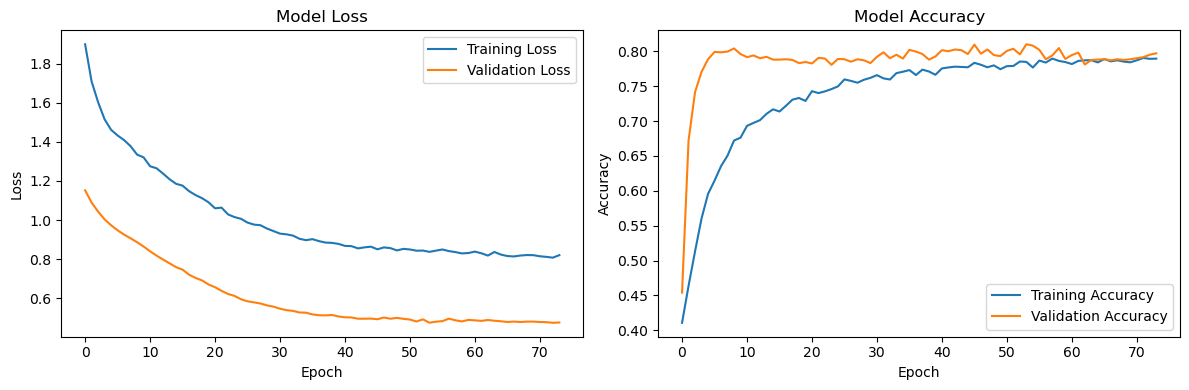

In [266]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
